https://www.wnyc.org/story/bronx-has-least-internet-connectivity-city/

### Review

This map looks great as far as representing the quantities it is trying to represent goes. I would hope for the background color of the first plot to be a __little less "subdued"__. In terms of selecting the right colors for free WIFI and limited WIFI, I think again, the plot could be served right, if more “robust” colors were used. And for the legend I think we could be a little more intuitive; for example we could bundle the __twelve providers into two groupings__. May be use a dictionary for a key value combination ? And the number of WIFI hot spots would make one curious as to how these hots spots are shared among the eight or so providers in each grouping

In [1]:
import io
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import urllib
import requests

import shapely
from fiona.crs import from_epsg

import json

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
os.getenv("PUIDATA")

'/nfshome/jl9200/PUIdata'

1. Download PUMA DATA

In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url,"file.gz")
! unzip -d $PUIDATA/pumadata file.gz

Archive:  file.gz
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_bdf27468-444f-4173-a0f6-be68e453dece.dbf  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_bdf27468-444f-4173-a0f6-be68e453dece.shp  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_bdf27468-444f-4173-a0f6-be68e453dece.shx  
  inflating: /nfshome/jl9200/PUIdata/pumadata/geo_export_bdf27468-444f-4173-a0f6-be68e453dece.prj  


In [4]:
directory = os.getenv("PUIDATA")+"/pumadata"
pumashp = gpd.GeoDataFrame.from_file(directory)

In [5]:
# check the crs
pumashp.crs

{'init': 'epsg:4326'}

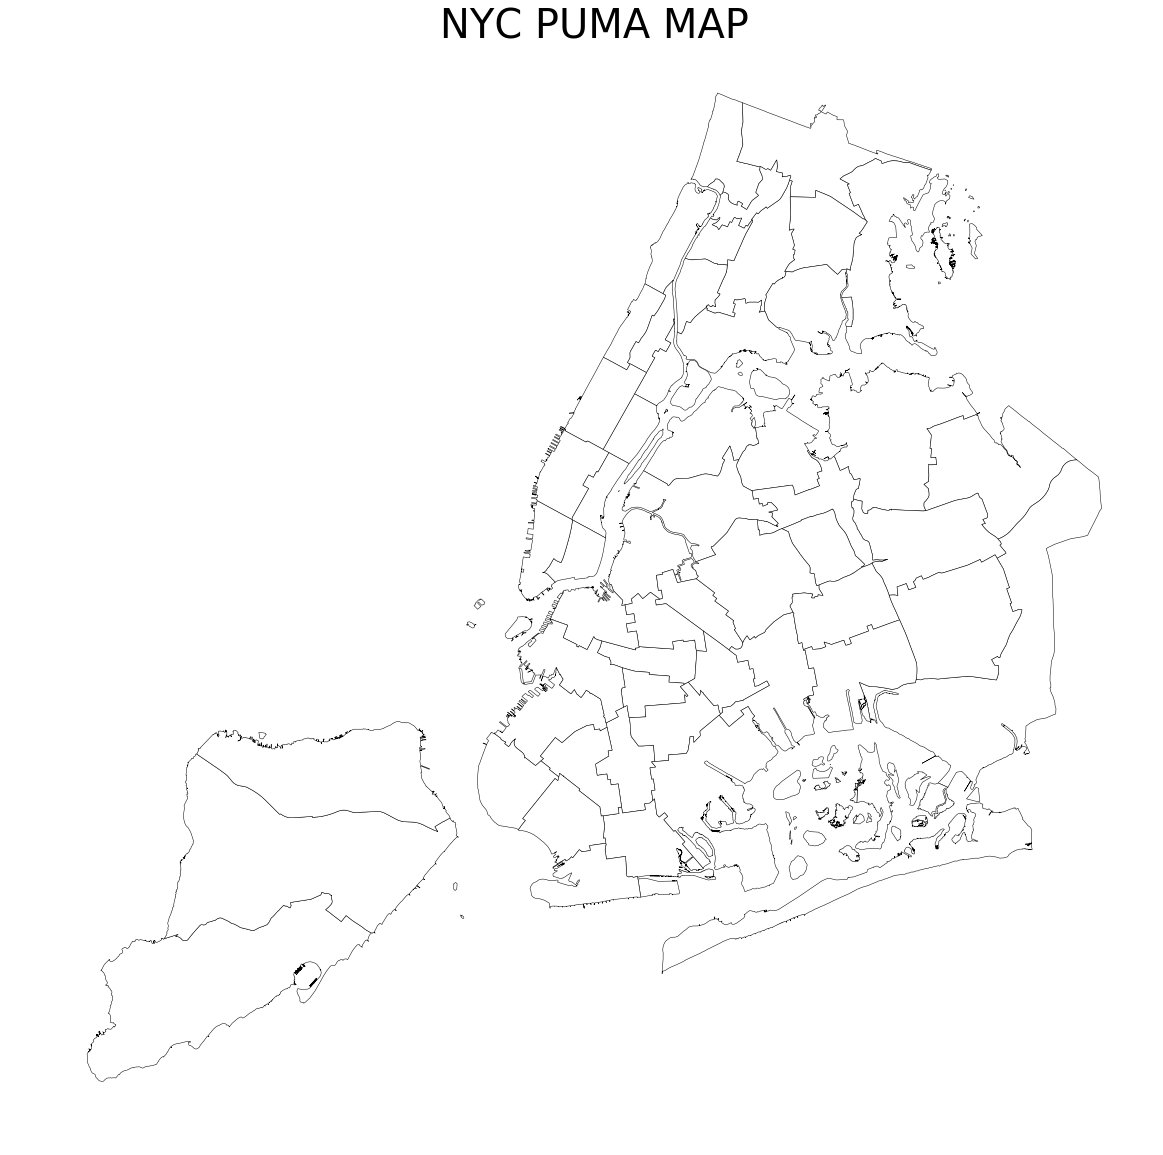

In [6]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
pumashp.plot(ax = ax,color = 'w',edgecolor = 'black',lw = 0.5)
ax.axis('off')
plt.title(r"NYC PUMA MAP",fontsize = 40)
plt.show()


Figure 1:  PUMA BOUNDARY OF NEW YORK CITY 

In [7]:
#### download census data

#### download linkNYC data

In [7]:
# data from (https://data.cityofnewyork.us/City-Government/NYC-Wi-Fi-Hotspot-Locations/yjub-udmw)

%time wifidata = pd.read_csv("https://data.cityofnewyork.us/api/views/yjub-udmw/rows.csv?accessType=DOWNLOAD",parse_dates=True)
wifidata.shape


CPU times: user 40 ms, sys: 20 ms, total: 60 ms
Wall time: 459 ms


(3345, 29)

In [9]:
# check null
wifidata.isnull().sum()

OBJECTID                   0
Borough                    0
Type                       0
Provider                   0
Name                     258
Location                   0
Latitude                   0
Longitude                  0
X                          0
Y                          0
Location_T                 0
Remarks                  571
City                       0
SSID                       0
SourceID                1089
Activated               1462
BoroCode                   0
BoroName                   0
NTACode                    0
NTAName                    0
CounDist                   0
Postcode                   0
BoroCD                     0
CT2010                     0
BCTCB2010                  0
BIN                        0
BBL                        0
DOITT_ID                   0
Location (Lat, Long)       0
dtype: int64

In [10]:
# df.dropna(subset = ['col1','col2],inplace = True)
# wifidata.dropna(subset = ['Latitude','Longitude'],inplace = True)

In [8]:
wifidata.head()

,OBJECTID,Borough,Type,Provider,Name,Location,Latitude,Longitude,X,Y,...,NTA,Council Distrcit,Postcode,BoroCD,Census Tract,BCTCB2010,BIN,BBL,DOITT_ID,"Location (Lat, Long)"
0,76,3,Free,NYCHA,0,138 Cumberland Walk,40.694382,-73.974614,991289.588599,192259.555163,...,Fort Greene,35,11205,302,18501,18501,3335253,3020410001,659,"(40.694382, -73.974614)"
1,77,3,Free,NYCHA,0,277 Myrtle Ave,40.693724,-73.977351,990530.669185,192019.618307,...,Fort Greene,35,11205,302,2901,2901,0,3020400001,660,"(40.693724, -73.977351)"
2,78,3,Free,NYCHA,0,152 N Elliott Walk,40.693740,-73.977796,990407.266217,192025.416196,...,Fort Greene,35,11205,302,2901,2901,3335247,3020400001,661,"(40.69374, -73.977796)"
3,79,3,Free,NYCHA,0,160 N Elliott Walk,40.693680,-73.977246,990559.845964,192003.595373,...,Fort Greene,35,11205,302,2901,2901,3345021,3020400001,662,"(40.69368, -73.977246)"
4,80,3,Free,NYCHA,0,293 Myrtle Ave,40.693509,-73.976981,990633.293324,191941.314330,...,Fort Greene,35,11205,302,2901,2901,3335246,3020400001,663,"(40.693509, -73.976981)"


In [9]:
wifidata.Provider = wifidata.Provider.astype(str)
wifidata.Longitude = wifidata.Longitude.astype(float)
wifidata.Latitude = wifidata.Latitude.astype(float)
wifidata.Type = wifidata.Type.astype(str)

In [10]:
print(wifidata.Type.unique())

['Free' 'Limited Free' 'Partner Site']


** We choose the wifi which is free or limited free **

In [27]:
wifidata2 = wifidata[wifidata['Type']!='Partner Site']

In [28]:
# combine lat and lon
wifidata2['lonlat'] = list(zip(wifidata2.Longitude,wifidata2.Latitude))
# use shapely.geometry.Point
wifidata2['geometry'] = wifidata2[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
wifidata2['IsLinkNYC'] = wifidata2.Provider.str.contains('LinkNYC')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
# just check number of the linkNYC spots
len(wifidata2[wifidata2.IsLinkNYC==True])

1867

In [31]:
linkNYC = pd.read_csv("https://data.cityofnewyork.us/api/views/3ktt-gd74/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*")

In [32]:
###

In [33]:
wifidata2 = gpd.GeoDataFrame(wifidata2)

In [34]:
wifidata2.to_crs = from_epsg(4326)

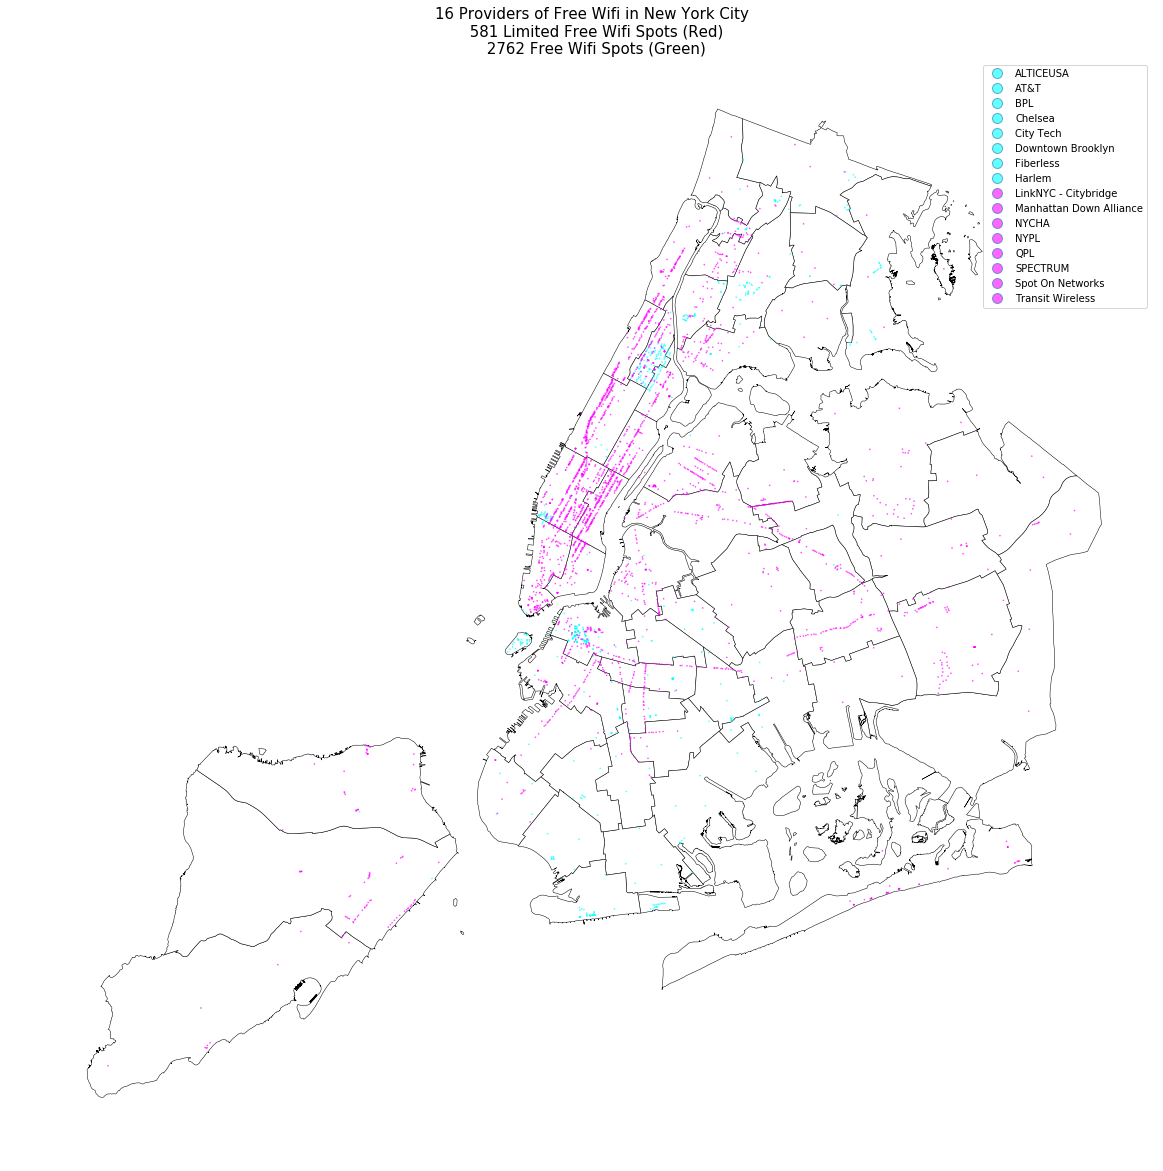

In [38]:

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)

# get 2 discrete color 
cmap2 = plt.get_cmap('cool', 2) 
pumashp.plot(ax = ax,color = 'w',edgecolor = 'black',lw = 0.5)
# based on the comments I add the alpha to make the plot a little bit subtle
wifidata2.plot(ax = ax, column = 'Provider',markersize = 0.5,marker = 'o',cmap = cmap2,legend = True,alpha = 0.6)
ax.axis('off')
legendtitle = '{} Providers of Free Wifi in New York City \n {} Limited Free Wifi Spots (Red)\n {} Free Wifi Spots (Green)'\
.format(len(wifidata2.Provider.unique()),
        len(wifidata2[wifidata2.Type == 'Limited Free'].index),
        len(wifidata2[wifidata2.Type == 'Free'].index))
plt.title(legendtitle, fontsize  = 15)
plt.show()








Figure 2:  WIFI SPOTS PROVIDERS IN NEW YORK CITY

In [39]:
# load the ACS 1yr data from json
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET',url)
aff1y = json.loads(resp.text)

In [40]:
affkeys = np.array(list(aff1y['variables'].keys()))
len(affkeys)

31710

In [41]:
# extract variables of B28002 which is relate to internet accessibility
[(k,aff1y['variables'][k]['label']) for k in affkeys if k.startswith('B28002')]

[('B28002_003E',
  'Estimate!!Total!!With an Internet subscription!!Dial-up with no other type of Internet subscription'),
 ('B28002_002E', 'Estimate!!Total!!With an Internet subscription'),
 ('B28002_013E', 'Estimate!!Total!!No Internet access'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_011E',
  'Estimate!!Total!!With an Internet subscription!!Other service with no other type of Internet subscription'),
 ('B28002_009E',
  'Estimate!!Total!!With an Internet subscription!!Satellite Internet service'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_012E', 'Estimate!!Total!!Internet access without a subscription'),
 ('B28002_006E',
  'Estimate!!Total!!With an Internet subscription!!Cellular data plan!!Cellular data plan with no other type of Internet subscription'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as 

In [42]:
# now we need to chose the neighborhood without internet access
# B28002_013E with no internet access
NoKey = 'B28002_013E'
aff1y['variables'][NoKey]


{'attributes': 'B28002_013M,B28002_013EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!No Internet access',
 'limit': 0,
 'predicateType': 'int'}

In [43]:
# keyword for the number of households

keyhouseholds = 'B28002_001E'
aff1y['variables'][keyhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [45]:
# get the household with no internet access
from censusAPI import myAPI
url2 = 'https://api.census.gov/data/2016/acs/acs1?get=' + NoKey +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp2 = requests.request('GET',url2)
HH_noint = pd.read_csv(io.StringIO(resp2.content.decode('utf-8').replace('[','').replace(']','')))
HH_noint.head()

,B28002_013E,NAME,state,public use microdata area,Unnamed: 4
0,6683,"St. Lawrence County PUMA, New York",36,100,NaN
1,12934,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,8484,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,6456,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,10668,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [46]:
# getting the first row of the table: the total number of households
url3 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI

resp3 = requests.request('GET',url3)
pumaPP = pd.read_csv(io.StringIO(resp3.content.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [47]:
pumaPP = pumaPP.merge(HH_noint)
pumaPP['NoInt'] = round(pumaPP['B28002_013E']/pumaPP['B28002_001E'],4)*100
pumaPP.drop(['Unnamed: 4'],axis =1,inplace = True)


In [48]:
pumaPP.columns = ["TotalHousehold","Name","State","puma","TotalHouseholdNoInt","pcNoInt"]
pumaPP.puma = pumaPP.puma.astype(int)

In [49]:
pumashp.puma = pumashp.puma.astype(int)

In [50]:
pumashp2 = pumashp.merge(pumaPP, on = "puma")

In [51]:
pumashp2.head()

,puma,shape_area,shape_leng,geometry,TotalHousehold,Name,State,TotalHouseholdNoInt,pcNoInt
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,42158,"NYC-Bronx Community District 8--Riverdale, Fie...",36,5771,13.69
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",49817,"NYC-Bronx Community District 12--Wakefield, Wi...",36,9447,18.96
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,44329,"NYC-Bronx Community District 10--Co-op City, P...",36,5835,13.16
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",44476,NYC-Bronx Community District 11--Pelham Parkwa...,36,8569,19.27
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,55953,NYC-Brooklyn Community District 14--Flatbush &...,36,10199,18.23


In [52]:
# see the top 10 with high presentage of no Internet access families
pumashp2.sort_values(by = ['pcNoInt'],ascending = False)[:10]

,puma,shape_area,shape_leng,geometry,TotalHousehold,Name,State,TotalHouseholdNoInt,pcNoInt
24,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,76131,NYC-Manhattan Community District 3--Chinatown ...,36,23686,31.11
17,4014,8.768042e+07,51089.073159,"POLYGON ((-73.9781907435932 40.64752599151113,...",42114,NYC-Brooklyn Community District 12--Borough Pa...,36,13054,31.00
12,3710,1.377966e+08,91086.012338,(POLYGON ((-73.89680883223774 40.7958084451597...,52756,NYC-Bronx Community District 1 & 2--Hunts Poin...,36,15186,28.79
6,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,58706,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,16181,27.56
8,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",46654,NYC-Bronx Community District 5--Morris Heights...,36,12643,27.10
34,4007,7.220681e+07,44862.448657,"POLYGON ((-73.92281106533045 40.6670717607133,...",42579,NYC-Brooklyn Community District 16--Brownsvill...,36,11087,26.04
10,3708,5.589695e+07,34852.437966,POLYGON ((-73.91046008330409 40.84279164297445...,50192,"NYC-Bronx Community District 4--Concourse, Hig...",36,12461,24.83
29,4001,1.149292e+08,74076.375782,POLYGON ((-73.96736391699473 40.71648367905524...,66037,NYC-Brooklyn Community District 1--Greenpoint ...,36,15796,23.92
19,3804,6.461212e+07,62599.500502,(POLYGON ((-73.92133752419279 40.8008521075021...,51915,NYC-Manhattan Community District 11--East Harl...,36,12121,23.35
42,4103,3.298601e+08,144145.949178,(POLYGON ((-73.86788407404643 40.7873610366938...,84004,"NYC-Queens Community District 7--Flushing, Mur...",36,19181,22.83


In [75]:
wifidata2

,OBJECTID,Borough,Type,Provider,Name,Location,Latitude,Longitude,X,Y,...,BoroCD,Census Tract,BCTCB2010,BIN,BBL,DOITT_ID,"Location (Lat, Long)",lonlat,geometry,IsLinkNYC
0,76,3,Free,NYCHA,0,138 Cumberland Walk,40.694382,-73.974614,9.912896e+05,192259.555163,...,302,18501,18501,3335253,3020410001,659,"(40.694382, -73.974614)","(-73.974614, 40.694382)",POINT (-73.974614 40.694382),False
1,77,3,Free,NYCHA,0,277 Myrtle Ave,40.693724,-73.977351,9.905307e+05,192019.618307,...,302,2901,2901,0,3020400001,660,"(40.693724, -73.977351)","(-73.977351, 40.693724)",POINT (-73.977351 40.693724),False
2,78,3,Free,NYCHA,0,152 N Elliott Walk,40.693740,-73.977796,9.904073e+05,192025.416196,...,302,2901,2901,3335247,3020400001,661,"(40.69374, -73.977796)","(-73.977796, 40.69374)",POINT (-73.977796 40.69374000000001),False
3,79,3,Free,NYCHA,0,160 N Elliott Walk,40.693680,-73.977246,9.905598e+05,192003.595373,...,302,2901,2901,3345021,3020400001,662,"(40.69368, -73.977246)","(-73.977246, 40.69368)",POINT (-73.97724599999999 40.69368),False
4,80,3,Free,NYCHA,0,293 Myrtle Ave,40.693509,-73.976981,9.906333e+05,191941.314330,...,302,2901,2901,3335246,3020400001,663,"(40.693509, -73.976981)","(-73.976981, 40.693509)",POINT (-73.97698100000001 40.69350900000001),False
5,81,3,Free,NYCHA,0,297 Myrtle Ave,40.693493,-73.976635,9.907292e+05,191935.510536,...,302,2901,2901,3335246,3020400001,664,"(40.693493, -73.976635)","(-73.976635, 40.693493)",POINT (-73.976635 40.693493),False
6,37,2,Limited Free,ALTICEUSA,Seton Falls Park,C/O E 233RD ST & WILDER AV,40.888783,-73.840133,1.028453e+06,263125.892433,...,212,426,426,0,0,905,"(40.888783, -73.840133)","(-73.840133, 40.888783)",POINT (-73.84013299999999 40.888783),False
7,75,3,Free,NYCHA,0,132 Carlton Ave,40.693392,-73.973923,9.914813e+05,191898.925307,...,302,18501,18501,3335252,3020410001,658,"(40.693392, -73.973923)","(-73.973923, 40.693392)",POINT (-73.973923 40.693392),False
8,9347,4,Free,LinkNYC - Citybridge,qu-01-125165,37-02 ASTORIA BOULEVARD SOUTH,40.769096,-73.912837,1.008394e+06,219491.021330,...,401,6502,6502,4010183,4006530040,4850,"(40.769096, -73.912837)","(-73.912837, 40.769096)",POINT (-73.912837 40.769096),True
9,16,2,Limited Free,ALTICEUSA,Poe Park,Playground area,40.864781,-73.894626,1.013396e+06,254358.205244,...,207,39901,39901,0,2031550001,884,"(40.864781, -73.894626)","(-73.894626, 40.864781)",POINT (-73.894626 40.864781),False


In [77]:
freewifi = wifidata2.groupby(['Provider'],as_index=False).count()[['Provider','OBJECTID']].rename(index = str,columns ={'count':'OBJECTID'})

In [87]:
dict_fwifi = freewifi.to_dict('split')

16

[237, 27, 59, 30, 11, 100, 30, 128, 1867, 36, 28, 90, 65, 343, 16, 276]

In [101]:
values = [dict_fwifi['data'][i][1] for i in range(len(dict_fwifi['data']))]
keys = [dict_fwifi['data'][i][0] for i in range(len(dict_fwifi['data']))]

In [103]:
dicts={}
for i in range(len(keys)):
    dicts[keys[i]] = values[i]

In [104]:
dicts

{'ALTICEUSA': 237,
 'AT&T': 27,
 'BPL': 59,
 'Chelsea': 30,
 'City Tech': 11,
 'Downtown Brooklyn': 100,
 'Fiberless': 30,
 'Harlem': 128,
 'LinkNYC - Citybridge': 1867,
 'Manhattan Down Alliance': 36,
 'NYCHA': 28,
 'NYPL': 90,
 'QPL': 65,
 'SPECTRUM': 343,
 'Spot On Networks': 16,
 'Transit Wireless': 276}

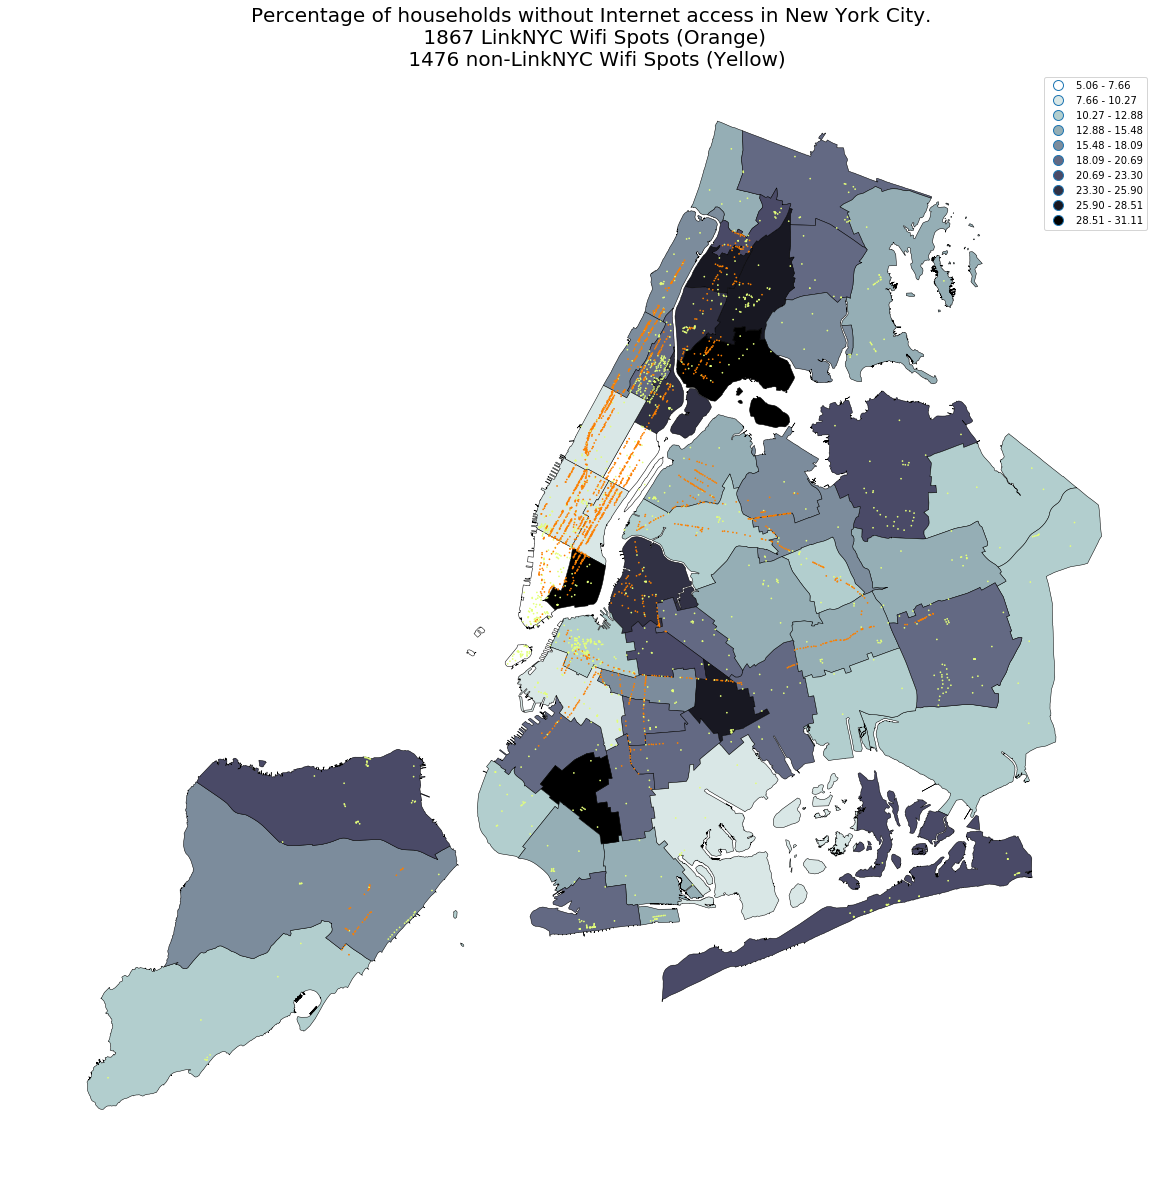

In [106]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
cmap3 = plt.get_cmap('Wistia',2)
pumashp2.plot(ax = ax,column = 'pcNoInt', cmap = 'bone_r',scheme = 'Equal_interval', k =10, edgecolor = 'black',lw = 0.5,legend = True)
wifidata2.plot(ax = ax,column = 'IsLinkNYC',markersize = 0.5,marker = 'o',cmap = cmap3)
ax.axis('off')



title = 'Percentage of households without Internet access in New York City. \n {} LinkNYC Wifi Spots (Orange) \n {} non-LinkNYC Wifi Spots (Yellow)'\
.format(len(wifidata2[wifidata2.IsLinkNYC==True]),len(wifidata2[wifidata2.IsLinkNYC==False]))

plt.title(title,fontsize = 20)

plt.show()

In [108]:
dicts.keys()

dict_keys(['City Tech', 'LinkNYC - Citybridge', 'Harlem', 'Fiberless', 'NYCHA', 'BPL', 'AT&T', 'Downtown Brooklyn', 'Manhattan Down Alliance', 'SPECTRUM', 'Chelsea', 'Spot On Networks', 'Transit Wireless', 'QPL', 'NYPL', 'ALTICEUSA'])

In [109]:
dicts.values()

dict_values([11, 1867, 128, 30, 28, 59, 27, 100, 36, 343, 30, 16, 276, 65, 90, 237])

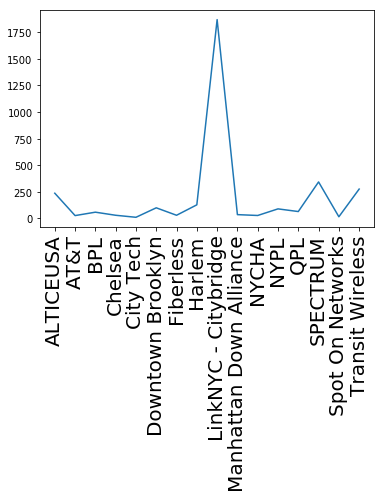

In [118]:
# based on the review, I will also add another plot for to collect all the key as Wifi Provider and the value as the number

lists = sorted(dicts.items())

x, y = zip(*lists)

plt.plot(x, y)

plt.xticks(rotation = 90, fontsize=20)
plt.show()

Figure 3: LINKNYC WIFI VS NON-LINKNYC WIFI ON TOP OF HOUSEHOLDS WITH NO INTERNECT ACCESS PERCENTAGE IN NYC **

In [ ]:
# download dataset of sidewalk coffee

# sidewalkcoffee = pd.read_csv("https://www1.nyc.gov/assets/dca/downloads/datasets/SWC.CSV")